In [1]:
import csv
import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import simpy

from pptx import Presentation
from pptx.util import Cm, Pt, Inches  # 単位変換機能
from pptx.dml.color import RGBColor   # 色指定用

/Users/hata/Library/Caches/pypoetry/virtualenvs/portfolio-blENujYS-py3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 108 (l) missing from font(s) Al Tarikh.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hata/Library/Caches/pypoetry/virtualenvs/portfolio-blENujYS-py3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 112 (p) missing from font(s) Al Tarikh.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hata/Library/Caches/pypoetry/virtualenvs/portfolio-blENujYS-py3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) Al Tarikh.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hata/Library/Caches/pypoetry/virtualenvs/portfolio-blENujYS-py3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) Al Tarikh.
  fig.canvas.print_figure(bytes_io, 

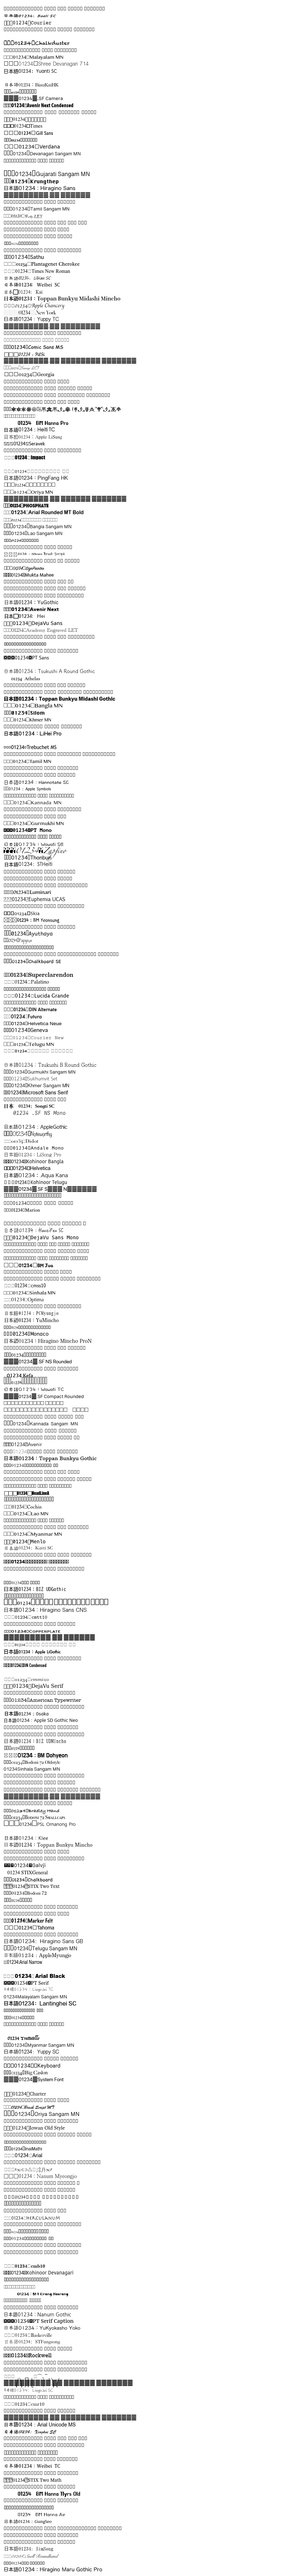

In [2]:
fonts = set([f.name for f in matplotlib.font_manager.fontManager.ttflist])

# 描画領域のサイズ調整
plt.figure(figsize=(10,len(fonts)/4))
 
# フォントの表示
for i, font in enumerate(fonts):
    plt.text(0, i, f"日本語01234：{font}", fontname=font)
    
# 見やすいように軸を消す
plt.ylim(0, len(fonts))
plt.axis("off")
plt.show()

matplotlib.matplotlib_fname()

# 使い方

- [投信信託協会のHP](https://www.toushin.or.jp/)から[投信総合検索ライブラリー](https://toushin-lib.fwg.ne.jp/FdsWeb/)へアクセスし，目的のファンドを検索してチャートのページを開いてcsvでダウンロードして分析する
- csvは 投信名.csv にリネームする
- 本スクリプトでは投信名でcsvファイルが存在するとして動作する

## 設定

In [2]:
# settings
mutual_fund_names = [ #'東京海上セレクション・物価連動国債'
                     #, 'たわらノーロード全世界株式'
                     #, 'ｅＭＡＸＩＳ　Ｓｌｉｍ米国株式（Ｓ＆Ｐ５００）'
                     #, 'ｅＭＡＸＩＳ　Ｓｌｉｍ全世界株式（オール・カントリー）'
                     #, '上場インデックスファンドＴＯＰＩＸ'
                     'ＭＡＸＩＳトピックス上場投信'  # 10年以上
                     , 'ＮＥＸＴ　ＦＵＮＤＳ金価格連動型上場投信'  # 10年以上
                     , '上場インデックスファンド海外先進国株式（ＭＳＣＩ－ＫＯＫＵＳＡＩ）'  # 10年以上
                     , '上場インデックスファンド米国株式（Ｓ＆Ｐ５００）'  # 10年以上
                     , 'インデックスコレクション（国内債券）'  # 10年以上
                     , 'インデックスコレクション（外国債券）'  # 10年以上
                    ]
jpdate_splitter = re.compile('[年月日]')
index_column = '年月日'
data_column = '基準価額(円)'

#sns.set(font='Ricty Diminished')
sns.set_style('whitegrid')

# output settings
pptx_file = 'report-{dt}.pptx'.format(dt=datetime.datetime.now().strftime('%Y%m%d'))
fig_dir = './img'

## 基本関数

In [3]:
def to_date(datestr):
    '''input is date string joined by date_splitter

    now only jp date format is implemented.
    '''
    if datestr.find('年') > 0:
        date_list = jpdate_splitter.split(datestr)
        if len(date_list) < 3:
            raise Exception(f'invalid date string: {datestr}')
        return datetime.date(*list(map(int, date_list[:3])))
    else:
        raise Exception(f'unknown date format: {datestr}')

In [4]:
def load_csv(mutual_fund_name):
    if os.path.isfile(mutual_fund_name+'.csv'):
        data = pd.read_csv(mutual_fund_name+'.csv', encoding='932')
        #with open(mutual_fund_name+'.csv') as fobj:
        #    cobj = csv.reader(fobj.read().rstrip().splitlines())
        #    data = [row for row in cobj]
    else:
        raise Exception(f'No such mutual fund data: {mutual_fund_name}')
    data[index_column] = data[index_column].apply(to_date)
    series = data.set_index(index_column)[data_column]
    series.name = mutual_fund_name
    return series

## 出力設定

In [5]:
# 出力フォーマット
class mkPpts():
    def __init__(self, filename, fig_dir, template=None):
        '''スライドのサイズやプレースホルダの位置はテンプレートのpptxを編集する
        '''
        if template is None or not os.path.isfile(template):
            self.prs = Presentation()
        else:
            self.prs = Presentation(template)
        self.filename = filename
        self.fig_dir = fig_dir

    def make_title_page(self, title_text='title', subtitle_text='subtitle'):
        title_slide = self.prs.slides.add_slide(self.prs.slide_layouts[0])
        title = title_slide.placeholders[0]
        subtitle = title_slide.placeholders[1]
        title.text = title_text
        subtitle.text = subtitle_text

    def make_single_fig_page(self, title_text, img_path):
        slide = self.prs.slides.add_slide(self.prs.slide_layouts[5])
        title = slide.placeholders[0]
        title.text = title_text

        slide.shapes.add_picture(img_path, Cm(7.36), Cm(3.36),  Cm(19.1), Cm(15.28)) # X座標、Y座標、横幅、縦幅

    def save(self):
        '''over write file
        '''
        if os.path.isfile(self.filename):
            os.remove(self.filename)
        self.prs.save(self.filename)

## データ読み込み

In [6]:
data = [load_csv(mutual_fund_name) for mutual_fund_name in mutual_fund_names]
dataframe = pd.concat(data, axis=1, join='inner')
relative_df = dataframe/dataframe.loc[dataframe.index[0]]

## データ概略プロット

In [7]:
plt.figure()
relative_df.plot()
plt.savefig(fig_dir+'/base_plot.png')
plt.close('all')


# シミュレーション

## 要件

- PS = new PortfolioSims(attr) でシミュレータを構築
- 指定するパラメタは
    - 期間: 開始日，終了日
    - リバランス条件
        - 定期リバランスの場合は，リバランス日
        - 乖離率リバランスの場合は，乖離率
        - ノーバイリバランスの場合は，積立金額をポートフォリオに近づくように購入する
    - 積立金額 `accum`
    - 積立日 `t_buy`
    - 銘柄 `add_pf (fund_name, weight)`
    - 税率 20.315%
- 考慮すること
    - 営業日は日本国内基準
    - 土日は翌営業日に取引成立
    - 約定は注文の翌営業日の終値
- 考慮しないこと
    - 一旦，ドル建て資産のドル貨決済は考えない
    - 外国税と外国税額控除は考えない，つまり国内で買える円建て投信のみ
    - 投信ごとの約定までの期間

## TODO

- 組合せを複数通り リスト化して、for で回せるようにする
- 結果をpptxで出力させる

## シミュレーション条件設定

In [11]:
# 最大期間
t_min = dataframe.index[0]
t_max = dataframe.index[-1]

# 日数計算用定数
d1 = datetime.timedelta(days=1)


# 積立条件リスト
## title, t0, t1, t_buy, rebalance_monthes, rebalance_threshold, pf
sim_list = [
    [ 'オルカン一本', t_min, t_max, 1, [], 1.0, pd.Series({'上場インデックスファンド海外先進国株式（ＭＳＣＩ－ＫＯＫＵＳＡＩ）':1.0})
    ],
    [ '金一本', t_min, t_max, 1, [], 1.0, pd.Series({'ＮＥＸＴ　ＦＵＮＤＳ金価格連動型上場投信':1.0})
    ],
    [ 'オルカン＋金', t_min, t_max, 1, [], 1.0, pd.Series({'上場インデックスファンド海外先進国株式（ＭＳＣＩ－ＫＯＫＵＳＡＩ）':2.0,  # weight
                                                         'ＮＥＸＴ　ＦＵＮＤＳ金価格連動型上場投信': 2.0,
                                                        })
    ],
    [ 'オルカン＋金 1%リバランス', t_min, t_max, 1, [3,], 0.01 , pd.Series({'上場インデックスファンド海外先進国株式（ＭＳＣＩ－ＫＯＫＵＳＡＩ）':2.0,  # weight
                                                                        'ＮＥＸＴ　ＦＵＮＤＳ金価格連動型上場投信': 2.0,
                                                                       })
    ],
    [ 'オルカン＋金 10%リバランス', t_min, t_max, 1, [3,], 0.1 , pd.Series({'上場インデックスファンド海外先進国株式（ＭＳＣＩ－ＫＯＫＵＳＡＩ）':2.0,  # weight
                                                                        'ＮＥＸＴ　ＦＵＮＤＳ金価格連動型上場投信': 2.0,
                                                                        })
    ],
]

## 月に1度 初めて DATE >= t_buy を満たした時に accum 円だけ積み立てる
accum = 100000

# 税率
tax_rate = 0.20315

## シミュレーション

In [12]:
def simulator(title, t0, t1, t_buy, rebalance_monthes, rebalance_threshold, pf):
    '''シミュレーション関数

    Parameter
    ---------
    title : string
        slide title
    t0 : datetime.datetime
        start time of simulation
    t1 : datetime.datetime
        end time of simulation
    t_buy : int
        the first day that is larger than `t_buy` in this month, buy portfolio
    rebalance_monthes : list
        a list of monthes when rebalance will be done
    rebalance_threshold : float
        if one or more portfolio different from target portfolio, rebalance will be done
    pf : pd.Series
        target portfolio name and weight

    Return
    ------
    pf_data : pd.DataFrame
        simulated time series
    pf_genka : pd.DataFrame
        原価の時系列。リバランスした場合、購入額が原価として加算されるので、投資金額とは異なる
    principal : int
        投資元本。投資に費した元の金額。リバランスしても変動しない。

    Sample
    ------
    following sample means, 2/3 of portfolio is AAA and the rest 1/3 is BBB.
    ```
    pf = pd.Series({'mutual fund AAA': 2.0,
                    'mutual fund BBB': 1.0,
                    })
    ```
    '''

    prev_month = 0
    pf_data = None
    i = 0

    # 読み込み済データからポートフォリオの対象期間を抜き出し
    target = relative_df[pf.keys()][t0:t1]
    target_diff_rate = target.diff()/target.shift(1)
    # ポートフォリオを率に変換
    pf_rate = pf/pf.sum()

    for t in target.index:
        if prev_month != t.month:
            prev_month = t.month
            # reset
            bought = False
            rebalance = False
        if pf_data is not None:
            # 値動き
            pf_data.append((pf_data[-1]*(1+target_diff_rate.loc[t])).astype('int64'))  # 最新の値に変化率を乗算
            pf_data[-1].name = t  # 追加したpandas.Seriesのnameを時刻インデックスとする
            pf_genka.append(pf_genka[-1]+0)  # 原価は変更なし、0を足さないと参照が代入される
            pf_genka[-1].name = t
        if not bought and t.day > t_buy:
            # まだ買ってなくて，日がt_buyを越えていたら，購入してboughtフラグを立てる
            # > 演算子を使うことで，翌営業日に購入できる
            if pf_data is None:
                # 初回購入
                pf_data = [(accum*pf_rate).astype('int64')]
                pf_data[-1].name = t
                pf_genka = [(accum*pf_rate).astype('int64')]
                pf_genka[-1].name = t
                i = 1
            else:
                # 2回目以降の購入
                i += 1
                pf_data[-1] += accum*pf_rate  # 投資金額は目標PFの比率通りに購入する場合
                pf_genka[-1] += accum*pf_rate
            bought = True  # もう今月は買わない
        if not rebalance and t.month in rebalance_monthes:  # リバランスは月初めとする
            # まだリバランスしてないリバランス月の最初の営業日
            # 金額計算
            total = pf_data[-1].sum()  # 現在の総資産
            present_rate = pf_data[-1]/total  # 現在の資産比率
            target_pf = total*pf_rate  # 目標PF
    
            rebalance = True  # もう今月はリバランスしない
            # 乖離率を計算する
            if not np.any((present_rate-pf_rate).abs() > rebalance_threshold):  # any = 1つでもthresholdを越えていたら
                # 全ての資産の乖離率が閾値以内の場合はリバランスせず終了
                continue
    
            # 乖離率が閾値を越えているので，差分を計算して売却，納税，購入を行う
            # 売却額
            diff_value = pf_data[-1]-target_pf
            diff_value[diff_value<0] = 0  # 目標PFを下回っている資産の売却額は0
            # 売却原価
            diff_genka = diff_value/pf_data[-1]*pf_genka[-1]
            # 利益
            profit = diff_value - diff_genka
            profit[profit<0] = 0
            # 源泉徴収税額
            tax = profit * tax_rate
    
            # 修正売却額 (税額追加)
            sell_value = (diff_value + tax).astype('int64')
            # 修正後原価
            sell_genka = (sell_value/pf_data[-1]*pf_genka[-1]).astype('int64')
            # 修正後利益
            profit = sell_value - sell_genka
            profit[profit<0] = 0
            # 修正後源泉徴収
            tax = (profit * tax_rate).astype('int64')
            # 税引き後売却額
            total_sell = (sell_value - tax).sum().astype('int64')
    
            # 目標購入額
            buy_value = target_pf - pf_data[-1]
            buy_value[buy_value<0] = 0
            total_buy = buy_value.sum()
            tax_discount_rate = total_sell/total_buy
            buy_value *= tax_discount_rate
            buy_value = buy_value.astype('int64')
    
            # 売却
            pf_data[-1] -= sell_value
            pf_genka[-1] -= sell_genka
            # 購入
            pf_data[-1] += buy_value
            pf_genka[-1] += buy_value
    
    pf_data = pd.DataFrame(pf_data)
    pf_genka = pd.DataFrame(pf_genka)
    pf_genka.columns += '原価'
    return (pf_data, pf_genka, accum*i)

In [13]:
# 作成
prs = mkPpts(pptx_file, fig_dir,template='template.pptx')
prs.make_title_page('投資シミュレーション', datetime.datetime.now().strftime('%Y-%m-%d'))
prs.make_single_fig_page('ベースの投信時系列プロット', f'{fig_dir}/base_plot.png')

for i,sim_condition in enumerate(sim_list):
    title, t0, t1, t_buy, rebalane_monthes, rebalance_threshold, pf = sim_condition
    pf_data, pf_genka, principal = simulator(*sim_condition)

    plotdata = pd.concat([pf_data, pf_genka], axis=1)
    plotdata['総額'] = pf_data.sum(axis=1)
    plotdata['総原価'] = pf_genka.sum(axis=1)
    total_return = pf_data.sum(axis=1)[t1]

    plt.figure()
    plotdata.plot()
    plt.savefig(fig_dir + f'/{i}.png')
    plt.close('all')
    prs.make_single_fig_page(title, f'{fig_dir}/{i}.png')
    print(f'{i}番目シミュレーション', title)
    print(f'総投資額 {principal}, 総額 {total_return}, 利益率 {total_return/principal:0.2f}')
prs.save()
del(prs)

0番目シミュレーション オルカン一本
総投資額 17100000, 総額 54528835.0, 利益率 3.19
1番目シミュレーション 金一本
総投資額 17100000, 総額 39220104.0, 利益率 2.29
2番目シミュレーション オルカン＋金
総投資額 17100000, 総額 46869876.0, 利益率 2.74
3番目シミュレーション オルカン＋金 1%リバランス
総投資額 17100000, 総額 45777907.0, 利益率 2.68
4番目シミュレーション オルカン＋金 10%リバランス
総投資額 17100000, 総額 46189780.0, 利益率 2.70


# 基本アルゴリズム

以下、動作確認用のスクリプト

In [150]:
d1 = datetime.timedelta(days=1)
#t0 = t_min
t0 = datetime.date(2015,1,1)
#t1 = t0 + d1*365*5
t1 = t_max

# ポートフォリオの追加
pf = pd.Series(
    {'上場インデックスファンド海外先進国株式（ＭＳＣＩ－ＫＯＫＵＳＡＩ）':2.0,  # weight
     'ＮＥＸＴ　ＦＵＮＤＳ金価格連動型上場投信': 2.0,
     #'インデックスコレクション（外国債券）':2.0
    })

# 積立金額
accum = 100000

# 積立日
t_buy = 13

# リバランス月
# rebalance_monthes = [3,6,9,12]  # 年4
rebalance_monthes = [3]  # 年1

# リバランス閾値
#rebalance_threshold = 0.01  # 1%以上の乖離があればリバランスする
rebalance_threshold = 0.001  # 0.1%以上の乖離があればリバランスする

# 税率
tax_rate = 0.20315

In [151]:
target = relative_df[pf.keys()][t0:t1]
target_diff_rate = target.diff()/target.shift(1)
# ポートフォリオを率に変換
pf_rate = pf/pf.sum()

In [152]:
# リバランスなし
prev_month = 0
pf_data = None
total_bet = 0

for t in target.index:
    if prev_month != t.month:
        prev_month = t.month
        # reset
        bought = False
    if pf_data is not None:
        # 値動き
        pf_data.append((pf_data[-1]*(1+target_diff_rate.loc[t])).astype('int64'))  # 最新の値に変化率を乗算
        pf_data[-1].name = t  # 追加したpandas.Seriesのnameを時刻インデックスとする
        pf_genka.append(pf_genka[-1]+0)  # 原価は変更なし
        pf_genka[-1].name = t
    if not bought and t.day > t_buy:
        # まだ買ってなくて，日がt_buyを越えていたら，購入してboughtフラグを立てる
        # > 演算子を使うことで，翌営業日に購入できる
        if pf_data is None:
            # 初回購入
            pf_data = [(accum*pf_rate).astype('int64')]
            pf_data[-1].name = t
            pf_genka = [(accum*pf_rate).astype('int64')]
            pf_genka[-1].name = t
            total_bet += accum
        else:
            # 2回目以降の購入
            pf_data[-1] += accum*pf_rate  # 投資金額は目標PFの比率通りに購入する場合
            pf_genka[-1] += accum*pf_rate
            total_bet += accum
        bought = True  # もう今月は買わない

pf_data = pd.DataFrame(pf_data)
pf_genka = pd.DataFrame(pf_genka)
pf_genka.columns += '原価'
pf_wo_rebalance = pd.concat([pf_data, pf_genka], axis=1)
pf_wo_rebalance['総額'] = pf_data.sum(axis=1)
pf_wo_rebalance['総原価'] = pf_genka.sum(axis=1)
pf_wo_rebalance_total_return = pf_data.sum(axis=1)[t1]

In [153]:
# 積立はPF通りで，リバランス時に売買でリバランスする

prev_month = 0
pf_data = None
i = 0

for t in target.index:
    if prev_month != t.month:
        prev_month = t.month
        # reset
        bought = False
        rebalance = False
    if pf_data is not None:
        # 値動き
        pf_data.append((pf_data[-1]*(1+target_diff_rate.loc[t])).astype('int64'))  # 最新の値に変化率を乗算
        pf_data[-1].name = t  # 追加したpandas.Seriesのnameを時刻インデックスとする
        pf_genka.append(pf_genka[-1]+0)  # 原価は変更なし、0を足さないと参照が代入される
        pf_genka[-1].name = t
    if not bought and t.day > t_buy:
        # まだ買ってなくて，日がt_buyを越えていたら，購入してboughtフラグを立てる
        # > 演算子を使うことで，翌営業日に購入できる
        if pf_data is None:
            # 初回購入
            pf_data = [(accum*pf_rate).astype('int64')]
            pf_data[-1].name = t
            pf_genka = [(accum*pf_rate).astype('int64')]
            pf_genka[-1].name = t
        else:
            # 2回目以降の購入
            pf_data[-1] += accum*pf_rate  # 投資金額は目標PFの比率通りに購入する場合
            pf_genka[-1] += accum*pf_rate
        bought = True  # もう今月は買わない
    if not rebalance and t.month in rebalance_monthes:  # リバランスは月初めとする
        # まだリバランスしてないリバランス月の最初の営業日
        # 金額計算
        total = pf_data[-1].sum()  # 現在の総資産
        present_rate = pf_data[-1]/total  # 現在の資産比率
        target_pf = total*pf_rate  # 目標PF

        rebalance = True  # もう今月はリバランスしない
        # 乖離率を計算する
        if not np.any((present_rate-pf_rate).abs() > rebalance_threshold):  # any = 1つでもthresholdを越えていたら
            # 全ての資産の乖離率が閾値以内の場合はリバランスせず終了
            continue

        # 乖離率が閾値を越えているので，差分を計算して売却，納税，購入を行う
        # 売却額
        diff_value = pf_data[-1]-target_pf
        diff_value[diff_value<0] = 0  # 目標PFを下回っている資産の売却額は0
        # 売却原価
        diff_genka = diff_value/pf_data[-1]*pf_genka[-1]
        # 利益
        profit = diff_value - diff_genka
        profit[profit<0] = 0
        # 源泉徴収税額
        tax = profit * tax_rate

        # 修正売却額 (税額追加)
        sell_value = (diff_value + tax).astype('int64')
        # 修正後原価
        sell_genka = (sell_value/pf_data[-1]*pf_genka[-1]).astype('int64')
        # 修正後利益
        profit = sell_value - sell_genka
        profit[profit<0] = 0
        # 修正後源泉徴収
        tax = (profit * tax_rate).astype('int64')
        # 税引き後売却額
        total_sell = (sell_value - tax).sum().astype('int64')

        # 目標購入額
        buy_value = target_pf - pf_data[-1]
        buy_value[buy_value<0] = 0
        total_buy = buy_value.sum()
        tax_discount_rate = total_sell/total_buy
        buy_value *= tax_discount_rate
        buy_value = buy_value.astype('int64')

        # 売却
        pf_data[-1] -= sell_value
        pf_genka[-1] -= sell_genka
        # 購入
        pf_data[-1] += buy_value
        pf_genka[-1] += buy_value

pf_data = pd.DataFrame(pf_data)
pf_genka = pd.DataFrame(pf_genka)
pf_genka.columns += '原価'
pf_yearly_rebalance = pd.concat([pf_data, pf_genka], axis=1)
pf_yearly_rebalance['総額'] = pf_data.sum(axis=1)
pf_yearly_rebalance['総原価'] = pf_genka.sum(axis=1)
pf_yearly_rebalance_total_return = pf_data.sum(axis=1)[t1]

総投資額 12000000, 総額 26903485.0, 利益率 2.24


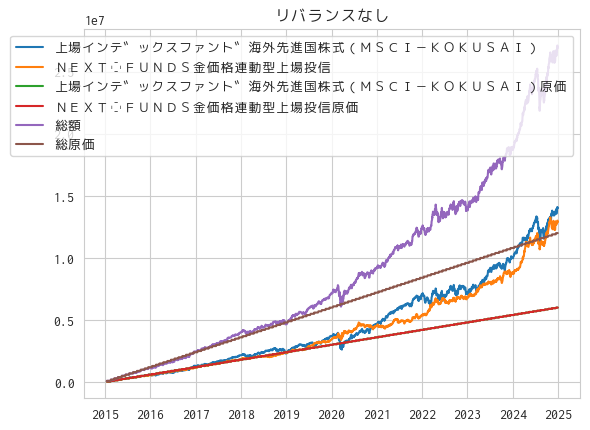

In [154]:
pf_wo_rebalance.plot(title='リバランスなし')
print(f'総投資額 {total_bet}, 総額 {pf_wo_rebalance_total_return}, 利益率 {pf_wo_rebalance_total_return/total_bet:0.2f}')

総投資額 12000000, 総額 26911704.0, 利益率 2.24


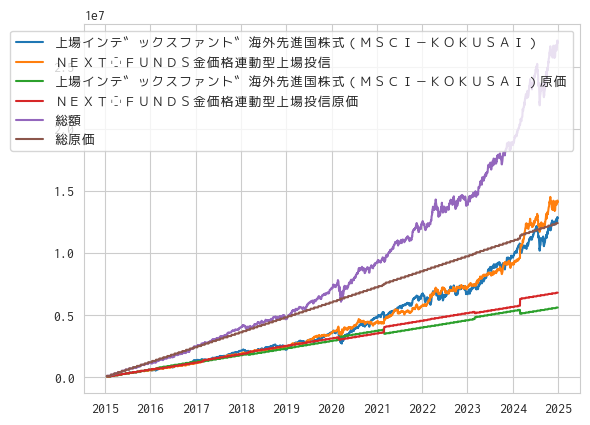

In [155]:
pf_yearly_rebalance.plot()
print(f'総投資額 {total_bet}, 総額 {pf_yearly_rebalance_total_return}, 利益率 {pf_yearly_rebalance_total_return/total_bet:0.2f}')